# Mito and ITS

this notebook assembles the mitochondrial genomes for all samples in the filtered dataset, it also genotypes the ITS fragments often used in single gene PCR identification of hybrids.  The goals is to see how many and which of our samples would be considered "hybrids" using traditional methods


need to run with ```sch_hae_scan/mito_assembly``` kernel


In [349]:
import os
from pathlib import Path
import glob
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import allel
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from matplotlib.pyplot import figure



In [350]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)
qsub="qsub -V -cwd -S /bin/bash -q high_mem.q -j y -p -1023" 
conda="conda activate {}/envs/novoplasty".format(proj_dir)

In [351]:
os.chdir(proj_dir)
Path("{}/mito_assembly".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/mito_assembly".format(results_dir))

## Mitochondrial genome assembly

Assembling mito genomes from a seed sequence with NOVOplast4.2. I generated the seed seqeunce by finding a "long" section fo the mitochondrial genome that was similar between S. haem and S. bovis.  Then I "neutralized it" so that it was equidistant from both species so as not to bias the results.

DQ157222.2 vs CM014335.1
```
Query  9409   ATAATTTTTAGAGAGTCTGAGAAAAATGGGGATTGGAGACCCCTTTATTAGACTTCGAAA  9468
Sbjct  6616   ............................................................  6675

Query  9469   TTTTAGTCCACAGTTAGAAACTGAAAGGGTTTGGCGGTAAATTAGATTCGTCCGGGGGAA  9528
Sbjct  6676   .........................................C..................  6735

Query  9529   TGTGCATATTAAAAAGATGATCCGCTAATTATTTTACTATAACAATTTCAGTTAGTGTAT  9588
Sbjct  6736   ..........................................T...A..C..........  6795

Query  9589   ATCCGTTTATAGATTTACGTCGAGAGACATCAAGTGAGTAAGAAATTATATAATTTAAGA  9648
Sbjct  6796   ..............................T.............................  6855

Query  9649   CAGGTCTATATGCTGCTAATGTTATAGGTGATTGTGCGTTACAATGATAAGTTAGGTAGA  9708
Sbjct  6856   ....................A.........G............G................  6915

Query  9709   TGAAATTCGCTTAAATATATAGGACTCGGAAGTAGGAGTAAAATAGTATGTTGCTTCGAA  9768
Sbjct  6916   ..............G...T.........................................  6975

Query  9769   GGTTGAAATAGTTTACGTACACATCGCCCGACAATCTCGGTGATAAATTGAGTTAAGTCG  9828
Sbjct  6976   ...............T............................................  7035

Query  9829   TAACATGGTAGTGCTTGAAGAATCAGGCGCTAGAATTAGATTGTCTTTGCTGACATATGA  9888
Sbjct  7036   ................................................
```

so i changed each of the mismatches to a third base that didn't match either sequence

```
Query  9409   ATAATTTTTAGAGAGTCTGAGAAAAATGGGGATTGGAGACCCCTTTATTAGACTTCGAAA  9468
Sbjct  6616   ............................................................  6675

Query  9469   TTTTAGTCCACAGTTAGAAACTGAAAGGGTTTGGCGGTAAAaTAGATTCGTCCGGGGGAA  9528
Sbjct  6676   .........................................C..................  6735

Query  9529   TGTGCATATTAAAAAGATGATCCGCTAATTATTTTACTATAAaAATaTCgGTTAGTGTAT  9588
Sbjct  6736   ..........................................T...A..C..........  6795

Query  9589   ATCCGTTTATAGATTTACGTCGAGAGACATgAAGTGAGTAAGAAATTATATAATTTAAGA  9648
Sbjct  6796   ..............................T.............................  6855

Query  9649   CAGGTCTATATGCTGCTAATcTTATAGGTGtTTGTGCGTTACAtTGATAAGTTAGGTAGA  9708
Sbjct  6856   ....................A.........G............G................  6915

Query  9709   TGAAATTCGCTTAAtTATcTAGGACTCGGAAGTAGGAGTAAAATAGTATGTTGCTTCGAA  9768
Sbjct  6916   ..............G...T.........................................  6975

Query  9769   GGTTGAAATAGTTTAgGTACACATCGCCCGACAATCTCGGTGATAAATTGAGTTAAGTCG  9828
Sbjct  6976   ...............T............................................  7035

Query  9829   TAACATGGTAGTGCTTGAAGAATCAGGCGCTAGAATTAGATTGTCTTTGCTGACATATGA  9888
Sbjct  7036   ................................................
```

The end results is a 480 bp alignment with only 11 mismatches to S. bovis and S. haem
```
TAATTTTTAGAGAGTCTGAGAAAAATGGGGATTGGAGACCCCTTTATTAGACTTCGAAATTTTAGTCCACAGTTAGAAAC
TGAAAGGGTTTGGCGGTAAAaTAGATTCGTCCGGGGGAATGTGCATATTAAAAAGATGATCCGCTAATTATTTTACTATA
AaAATaTCgGTTAGTGTATATCCGTTTATAGATTTACGTCGAGAGACATgAAGTGAGTAAGAAATTATATAATTTAAGAC
AGGTCTATATGCTGCTAATcTTATAGGTGtTTGTGCGTTACAtTGATAAGTTAGGTAGATGAAATTCGCTTAAtTATcTA
GGACTCGGAAGTAGGAGTAAAATAGTATGTTGCTTCGAAGGTTGAAATAGTTTAgGTACACATCGCCCGACAATCTCGGT
GATAAATTGAGTTAAGTCGTAACATGGTAGTGCTTGAAGAATCAGGCGCTAGAATTAGATTGTCTTTGCTGACATATGA
```

In [ ]:
PROJ_DIR="/master/nplatt/sch_hae_nigeria"
RESULTS_DIR="$PROJ_DIR/results"
QSUB="qsub -V -cwd -S /bin/bash -q high_mem.q -j y -p -1023" 
CONDA="conda activate $PROJ_DIR/envs/novoplasty"

echo -e ">bov_haem_mt_seed
TAATTTTTAGAGAGTCTGAGAAAAATGGGGATTGGAGACCCCTTTATTAGACTTCGAAATTTTAGTCCACAGTTAGAAAC
TGAAAGGGTTTGGCGGTAAAaTAGATTCGTCCGGGGGAATGTGCATATTAAAAAGATGATCCGCTAATTATTTTACTATA
AaAATaTCgGTTAGTGTATATCCGTTTATAGATTTACGTCGAGAGACATgAAGTGAGTAAGAAATTATATAATTTAAGAC
AGGTCTATATGCTGCTAATcTTATAGGTGtTTGTGCGTTACAtTGATAAGTTAGGTAGATGAAATTCGCTTAAtTATcTA
GGACTCGGAAGTAGGAGTAAAATAGTATGTTGCTTCGAAGGTTGAAATAGTTTAgGTACACATCGCCCGACAATCTCGGT
GATAAATTGAGTTAAGTCGTAACATGGTAGTGCTTGAAGAATCAGGCGCTAGAATTAGATTGTCTTTGCTGACATATGA" \
>seed_file.fas

SEED_FILE=$(pwd)/seed_file.fas


#get list of samples that are in the filtered vcf file

for SAMPLE in $(cat ../filter_genotypes/indvs_to_keep.list); do
    
    if [ ! -d $SAMPLE ]; then
        mkdir $SAMPLE
    fi

    cd $SAMPLE
    
    if [ -f "$SAMPLE"_novoplasty.log ]; then
        rm "$SAMPLE"_novoplasty.log
    fi
    
    
    R1_READS=$RESULTS_DIR"/filtered_reads/"$SAMPLE"_filtered_R1.fq.gz"
    R2_READS=$RESULTS_DIR"/filtered_reads/"$SAMPLE"_filtered_R2.fq.gz"

#make config file
echo "Project:
-----------------------
Project name          = $SAMPLE
Type                  = mito
Genome Range          = 12000-30000
K-mer                 = 33
Max memory            = 75
Extended log          = 0
Save assembled reads  = no
Seed Input            = $SEED_FILE
Extend seed directly  = no
Reference sequence    = 
Variance detection    = 
Chloroplast sequence  = 

Dataset 1:
-----------------------
Read Length           = 151
Insert size           = 250
Platform              = illumina
Single/Paired         = PE
Combined reads        = 
Forward reads         = $R1_READS
Reverse reads         = $R2_READS
Store Hash            =

Heteroplasmy:
-----------------------
MAF                   = 
HP exclude list       = 
PCR-free              = 

Optional:
-----------------------
Insert size auto      = yes
Use Quality Scores    = no
Output path           = . ">config.txt

    CMD="NOVOPlasty4.2.pl -c config.txt"

    echo "$CONDA; $CMD" | $QSUB -pe smp 12 -N n-"$SAMPLE"_novoplasty -o $RESULTS_DIR/logs/n-"$SAMPLE"_novoplasty 

    cd $RESULTS_DIR/mito_assembly
done

Now figure out a way to make a fasta file and align the genomes to one another

In [365]:
#for sample in ../filter_genotypes/indvs_to_keep.list

with open('../filter_genotypes/indvs_to_keep.list') as in_f:
    samples = in_f.read().splitlines()
    
seq_records=[]

lengths=[]
for sample in samples:
    seq_file = glob.glob("{}/C*".format(sample))
    
    for seq_record in SeqIO.parse(seq_file[0], "fasta"):
        new_id=seq_file[0].split("/")[1].replace(".fasta", "")
        seq_record.id=new_id.replace(" ", "_")
        seq_records.append(seq_record)
        lengths.append(len(seq_record.seq))
        break
        
SeqIO.write(seq_records, "mito_assemblies.fasta", "fasta")

SyntaxError: EOL while scanning string literal (<ipython-input-365-0b93d42eee6a>, line 14)

In [355]:
print("Mito assemblies range in size from {} to {} bp (median={})".format(min(lengths), max(lengths), int(np.array(lengths).mean())))
print("There are {} assemblies greater than 8kb".format((np.array(lengths)>8_000).sum()))


Mito assemblies range in size from 754 to 16577 bp (median=14654)
There are 154 assemblies greater than 8kb


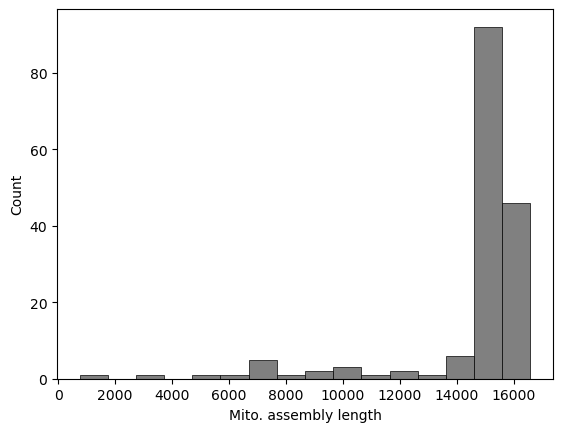

In [356]:
plt.hist(lengths, bins=16, edgecolor='black', linewidth=0.5, color="grey")
plt.xlabel("Mito. assembly length")
plt.ylabel("Count")
plt.show()

In [ ]:
#I manually added the S. matthei mito genome to the alignment (to serve as an outgroup)

In [362]:
#filtering out very small assemblies
long_assemblies=[]
for seq_record in SeqIO.parse("mito_assemblies.fasta", "fasta"):
    #print(seq_record.id)
    if len(seq_record.seq) > 4_000:
        long_assemblies.append(seq_record)
        
SeqIO.write(long_assemblies, "mito_assemblies_gt4kb.fasta", "fasta")

161

In [ ]:
#Align with muscle on a high_mem machine
! muscle -maxiters 8 -maxhours 3 -in mito_assemblies_gt4kb.fasta -out mito_assemblies_gt4kb_i8_h3.fasta

Once its is aligned the first time, I manually trimmed the alignment on the 5' and 3' ends to find the best aligned region.  After trimming I the re-aligned with muscle.

In [ ]:
! muscle -maxiters 8 -maxhours 3 -in mito_assemblies_gt4kb_i8_h3_trimmed.fasta -out mito_assemblies_gt4kb_i8_h3_trimmed_aligned.fasta

manually trimmed to the "good part of the alignment and built tree wtih raxml (1k bootstraps)"

In [ ]:
%%bash

sed -i 's/ /_/g' mito_assemblies_gt4kb_i8_h3_trimmed.fas                                                                         

raxml-ng --bootstrap \
    --bs-trees 1000 \
    --msa mito_assemblies_gt4kb_i8_h3_trimmed.fas \
    --model GTR+G \
    --prefix mito \
    --seed 12345 \
    --threads 24                                                       

## Extract ITS

Cattle as natural host for Schistosoma haematobium (Bilharz, 1852) Weinland, 1858 x Schistosoma bovis Sonsino, 1876 interactions, with new cercarial emergence and genetic patterns

MT158872.1 vs shv2

cattle profile MT158872

NW_023366102.1:1508664-1509323


In [109]:
Path("{}/its".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/its".format(results_dir))

first we need to find where the ITS marker is.  To do this I grabbed MT158872.1 (genbank accession) from the Savassi et al. 2020 paper and used the NCBI blastN against the v2 (SchHae_2.0 RefSeq assembly [GCF_000699445.2]) genome online.  The results `A885XHTW01N-Alignment.txt` file was saved and added to `results/its`.  Top hits shown here:


```
# blastn
# Iteration: 0
# Query: MT158872.1 Schistosoma bovis isolate BK19_1 small subunit ribosomal RNA gene, partial sequence; internal transcribed spacer 1 and 5.8S ribosomal RNA gene, complete sequence; and internal transcribed spacer 2, partial sequence.
# RID: A885XHTW01N
# Database: genomic/6185/GCF_000699445.2
# Fields: query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score
# 305 hits found
MT158872.1	NW_023366102.1	94.697	660	34	1	288	946	1508664	1509323	0.0	1030
MT158872.1	NW_023366102.1	93.902	164	10	0	137	300	967328	967165	4.85e-65	251
MT158872.1	NW_023366102.1	88.199	161	19	0	136	296	3979270	3979430	6.32e-51	205
MT158872.1	NW_023366102.1	95.312	64	3	0	1	64	20118	20181	5.54e-20	103
MT158872.1	NW_023366102.1	87.654	81	10	0	50	130	20218	20298	5.54e-20	102
MT158872.1	NW_023366102.1	85.294	68	10	0	358	425	20216	20283	6.33e-13	78.8
MT158872.1	NW_023366102.1	83.333	66	11	0	50	115	1508737	1508802	3.28e-10	70.7
MT158872.1	NW_023366102.1	97.436	39	1	0	84	122	20174	20212	3.99e-09	67.1
MT158872.1	NW_023366122.1	86.508	630	84	1	56	684	1319809	1320438	0.0	750
<...snip...>
```

Looking directly at the start-stop for the top hit...it looks like the ITS gene is somewhere around NW_023366102.1:1508664-1509323.  Unfortunatley this only covers 660 bp of the 946 in the sequence.  I am extending the coordinates to cover these possible regions.  Likely this could be caused by a missassembly. 

Finally ITS area to extract NW_023366102.1:1508364-1509623

In [262]:
#subset at NW_023366102.1:1508364-1509623
chrom="NW_023366102.1"
pos_start=1_508_364
pos_end=1_509_623
loter_df=pd.read_csv("{}/results/loter/vcf_files/loter_{}.csv".format(proj_dir, chrom), sep=",")
#loter_df=pd.read_csv("tmp.csv", sep=",")

loter_df

,Unnamed: 0,NW_023366102.1:877,NW_023366102.1:881,NW_023366102.1:909,NW_023366102.1:910,NW_023366102.1:913,NW_023366102.1:916,NW_023366102.1:930,NW_023366102.1:964,NW_023366102.1:965,...,NW_023366102.1:4409075,NW_023366102.1:4409078,NW_023366102.1:4409081,NW_023366102.1:4409087,NW_023366102.1:4409090,NW_023366102.1:4409094,NW_023366102.1:4409105,NW_023366102.1:4409138,NW_023366102.1:4409145,NW_023366102.1:4409152
0,Sb_NG_au_2.10_h1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Sb_NG_au_2.10_h2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sb_NG_au_2.13_h1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sb_NG_au_2.13_h2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sb_NG_au_2.5_h1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,ssp_niger_libore_169_h2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
294,ssp_niger_libore_173_h1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
295,ssp_niger_libore_173_h2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
296,ssp_zambia_kafue_71_h1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [263]:
loter_df.shape

(298, 488804)

In [267]:
#now subset at its positions
loter_df=loter_df.rename(columns={'Unnamed: 0': 'sample_id'})

In [292]:
poss=np.array([float(np.nan)])
for var_id in loter_df.columns[1:]:
    poss=np.append(poss, int(var_id.split(":")[-1]))


In [293]:
poss[0:100]

array([  nan,  877.,  881.,  909.,  910.,  913.,  916.,  930.,  964.,
        965.,  983.,  985.,  995., 1016., 1017., 1031., 1032., 1037.,
       1038., 1039., 1041., 1046., 1069., 1079., 1085., 1087., 1088.,
       1094., 1096., 1097., 1112., 1117., 1121., 1125., 1133., 1143.,
       1160., 1161., 1167., 1174., 1176., 1177., 1179., 1180., 1181.,
       1184., 1186., 1207., 1208., 1217., 1226., 1228., 1231., 1232.,
       1240., 1242., 1243., 1245., 1247., 1249., 1250., 1252., 1254.,
       1261., 1282., 1283., 1289., 1294., 1314., 1316., 1323., 1326.,
       1334., 1342., 1343., 1353., 1357., 1363., 1366., 1368., 1376.,
       1382., 1387., 1392., 1397., 1403., 1412., 1423., 1424., 1433.,
       1438., 1441., 1478., 1479., 1481., 1482., 1483., 1486., 1489.,
       1492.])

In [301]:
#its_hs=chr_hs[:,(chr_poss >= 1_508_364) & (chr_poss <= 1_509_623)]

# x=np.logical_and(poss>=1_508_364, poss<= 1_509_623)

# x
#comb.loc[:, criteria]
its_df=loter_df.loc[:,x]

In [302]:
its_df

,NW_023366102.1:1508372,NW_023366102.1:1508375,NW_023366102.1:1508410,NW_023366102.1:1508442,NW_023366102.1:1508450,NW_023366102.1:1508459,NW_023366102.1:1508461,NW_023366102.1:1508481,NW_023366102.1:1508483,NW_023366102.1:1508497,...,NW_023366102.1:1509457,NW_023366102.1:1509458,NW_023366102.1:1509466,NW_023366102.1:1509486,NW_023366102.1:1509495,NW_023366102.1:1509496,NW_023366102.1:1509502,NW_023366102.1:1509510,NW_023366102.1:1509512,NW_023366102.1:1509531
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
294,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
295,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
296,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [305]:
sample_ids=loter_df["sample_id"]

In [322]:
its_df.index=sample_ids

In [323]:
its_df

,NW_023366102.1:1508372,NW_023366102.1:1508375,NW_023366102.1:1508410,NW_023366102.1:1508442,NW_023366102.1:1508450,NW_023366102.1:1508459,NW_023366102.1:1508461,NW_023366102.1:1508481,NW_023366102.1:1508483,NW_023366102.1:1508497,...,NW_023366102.1:1509457,NW_023366102.1:1509458,NW_023366102.1:1509466,NW_023366102.1:1509486,NW_023366102.1:1509495,NW_023366102.1:1509496,NW_023366102.1:1509502,NW_023366102.1:1509510,NW_023366102.1:1509512,NW_023366102.1:1509531
sample_id,,,,,,,,,,,,,,,,,,,,,
Sb_NG_au_2.10_h1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sb_NG_au_2.10_h2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sb_NG_au_2.13_h1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sb_NG_au_2.13_h2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sb_NG_au_2.5_h1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_169_h2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp_niger_libore_173_h1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp_niger_libore_173_h2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


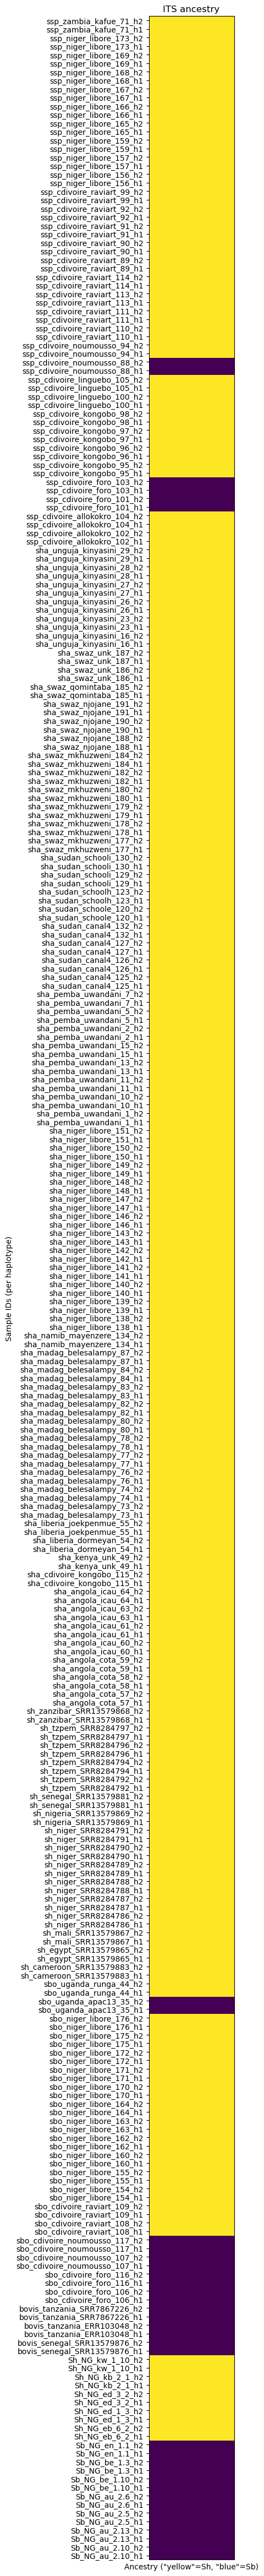

In [348]:
figure(figsize=(2, 60))

#only showing a ancestry at a single base since everything was phased the same entirely throgh the regions
plt.pcolor(its_df.loc[:,its_df.columns[0:1]])
plt.yticks(np.arange(0.5, len(its_df.index)), its_df.index[::])
plt.ylabel("Sample IDs (per haplotype)")
plt.xlabel("Ancestry (\"yellow\"=Sh, \"blue\"=Sb)")
plt.xticks([])
plt.title("ITS ancestry")
plt.savefig("its.svg")
plt.savefig("its.png", dpi=300)
plt.show()